In [1]:
import RAEAnglesUtilities as rae
from datetime import timedelta
import pandas as pd
from astropy.coordinates import SkyCoord, get_sun,FK4,get_body, EarthLocation

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import os
import glob
import numpy as np
import astropy.units as u
from tqdm.notebook import tqdm

In [2]:
def append_if_valid_median_std(signal, median_list, std_list):
    median = np.nanmedian(signal)
    std = np.nanstd(signal)#TODO: adjust this by the number of samples
    if not (np.isnan(median) or np.isnan(std)):
        median_list.append(median)
        std_list.append(std)

In [3]:
def append_if_valid_pair(
    pre_signal, post_signal,
    pre_median_list, pre_std_list,
    post_median_list, post_std_list
):
    pre_median = np.nanmedian(pre_signal)
    pre_std = np.nanstd(pre_signal)
    
    post_median = np.nanmedian(post_signal)
    post_std = np.nanstd(post_signal)
    # Check for NaNs or invalid values in both pre and post
    if (
        np.isfinite(pre_median) and np.isfinite(pre_std)
        and np.isfinite(post_median) and np.isfinite(post_std)
    ):
        pre_median_list.append(pre_median)
        pre_std_list.append(pre_std)
        
        post_median_list.append(post_median)
        post_std_list.append(post_std)

In [4]:
def occultationStatisticsIngressEgress(data, col='isVis', window=pd.Timedelta(minutes=10),antenn = 'rv2_coarse'):#edit this one to detect ingress and egress with variable time before and after
    freqs = data['frequency_band'].unique()
    stats = {}

    # Identify occultation periods
    occultation_changes = data[col].astype(int).diff()  # Detect changes in isVis
    start_times = data.index[(occultation_changes == -1)]  # False → True (start of occultation)
    end_times = data.index[(occultation_changes == 1)]  # True → False (end of occultation)

    # Ensure start_times and end_times align properly
    if len(end_times) > 0 and (len(start_times) == 0 or start_times[0] > end_times[0]):
        end_times = end_times[1:]  # Remove first end_time if it comes before any start_time

    if len(start_times) > len(end_times):
        start_times = start_times[:-1]  # Remove extra start_time if unmatched

    # Filter occultation periods that are at least 2 minutes long
    valid_pairs = [(s, e) for s, e in zip(start_times, end_times) if (e - s) >= pd.Timedelta(minutes=2)]
    
    # **Fix for empty valid_pairs**  
    if valid_pairs:
        start_times, end_times = zip(*valid_pairs)
    else:
        start_times, end_times = [], []

    # Loop over frequency bands
    for freq in tqdm(freqs, desc="Processing frequencies"):
        freq_data = data[data['frequency_band'] == freq]
        ingress_stats = {'preMedian': [], 'preStd': [], 'postMedian': [],'postStd': []}
        egress_stats = {'preMedian': [], 'preStd': [], 'postMedian': [],'postStd': []}

        for start, end in zip(start_times, end_times):
            pre_ingress = freq_data.loc[(freq_data.index >= start - window) & 
                                       (freq_data.index < start) & 
                                       (freq_data[col] == True)]
            
            post_ingress = freq_data.loc[(freq_data.index >= start) & 
                                       (freq_data.index < start+window) & 
                                       (freq_data[col] == False)]
            
            pre_egress = freq_data.loc[(freq_data.index > end-window) & 
                                        (freq_data.index <= end) & 
                                        (freq_data[col] == False)]
            post_egress = freq_data.loc[(freq_data.index > end) & 
                                        (freq_data.index <= end + window) & 
                                        (freq_data[col] == True)]
                        
            if pre_ingress.empty or post_ingress.empty:
                print(f"Skipping empty ingress period: {start} to {end}")
                continue
            if post_egress.empty or pre_egress.empty:
                print(f"Skipping empty non occult: {start} to {end}")
                continue
            # Extract signal values
            pre_ingress_data = pre_ingress[antenn]
            post_ingress_data = post_ingress[antenn]
            
            pre_egress_data = pre_egress[antenn]
            post_egress_data = post_egress[antenn]
            
            pre_ingress_sig = rae.sigmaClip(pre_ingress_data,n=5)
            post_ingress_sig = rae.sigmaClip(post_ingress_data,n=5)

            pre_egress_sig = rae.sigmaClip(pre_egress_data,n=5)
            post_egress_sig = rae.sigmaClip(post_egress_data,n=5)
            
            
            # Compute statistics
            append_if_valid_median_std(pre_ingress_sig, ingress_stats['preMedian'], ingress_stats['preStd'])
            append_if_valid_median_std(post_ingress_sig, ingress_stats['postMedian'], ingress_stats['postStd'])
            append_if_valid_median_std(pre_egress_sig, egress_stats['preMedian'], egress_stats['preStd'])
            append_if_valid_median_std(post_egress_sig, egress_stats['postMedian'], egress_stats['postStd'])



        
        # Store statistics for this frequency band
        stats[freq] = {
            'ingress': ingress_stats,
            'egress': egress_stats
        }

    return stats

In [5]:
def occultationStatisticsIngressEgressPairs(data, col='isVis', window=pd.Timedelta(minutes=10),antenn = 'rv2_coarse'):
    #this one insures that the pairs are in sync, since in the other function the pre or post could be nan one time while the other isnt, leading to an error
    freqs = data['frequency_band'].unique()
    stats = {}

    # Identify occultation periods
    occultation_changes = data[col].astype(int).diff()  # Detect changes in isVis
    start_times = data.index[(occultation_changes == -1)]  # False → True (start of occultation)
    end_times = data.index[(occultation_changes == 1)]  # True → False (end of occultation)

    # Ensure start_times and end_times align properly
    if len(end_times) > 0 and (len(start_times) == 0 or start_times[0] > end_times[0]):
        end_times = end_times[1:]  # Remove first end_time if it comes before any start_time

    if len(start_times) > len(end_times):
        start_times = start_times[:-1]  # Remove extra start_time if unmatched

    # Filter occultation periods that are at least 2 minutes long
    valid_pairs = [(s, e) for s, e in zip(start_times, end_times) if (e - s) >= pd.Timedelta(minutes=2)]
    
    # **Fix for empty valid_pairs**  
    if valid_pairs:
        start_times, end_times = zip(*valid_pairs)
    else:
        start_times, end_times = [], []

    # Loop over frequency bands
    for freq in tqdm(freqs, desc="Processing frequencies"):
        freq_data = data[data['frequency_band'] == freq]
        ingress_stats = {'preMedian': [], 'preStd': [], 'postMedian': [],'postStd': []}
        egress_stats = {'preMedian': [], 'preStd': [], 'postMedian': [],'postStd': []}

        for start, end in zip(start_times, end_times):
            pre_ingress = freq_data.loc[(freq_data.index >= start - window) & 
                                       (freq_data.index < start) & 
                                       (freq_data[col] == True)]
            
            post_ingress = freq_data.loc[(freq_data.index >= start) & 
                                       (freq_data.index < start+window) & 
                                       (freq_data[col] == False)]
            
            pre_egress = freq_data.loc[(freq_data.index > end-window) & 
                                        (freq_data.index <= end) & 
                                        (freq_data[col] == False)]
            post_egress = freq_data.loc[(freq_data.index > end) & 
                                        (freq_data.index <= end + window) & 
                                        (freq_data[col] == True)]
                        
            if pre_ingress.empty or post_ingress.empty:
                print(f"Skipping empty ingress period: {start} to {end}")
                continue
            if post_egress.empty or pre_egress.empty:
                print(f"Skipping empty non occult: {start} to {end}")
                continue
            # Extract signal values
            pre_ingress_data = pre_ingress[antenn]
            post_ingress_data = post_ingress[antenn]
            
            pre_egress_data = pre_egress[antenn]
            post_egress_data = post_egress[antenn]
            
            pre_ingress_sig = rae.sigmaClip(pre_ingress_data,n=5)
            post_ingress_sig = rae.sigmaClip(post_ingress_data,n=5)

            pre_egress_sig = rae.sigmaClip(pre_egress_data,n=5)
            post_egress_sig = rae.sigmaClip(post_egress_data,n=5)
            
            
            # Compute statistics
            append_if_valid_pair(pre_ingress_sig, post_ingress_sig,
                                ingress_stats['preMedian'], ingress_stats['preStd'],
                                ingress_stats['postMedian'], ingress_stats['postStd'])

            append_if_valid_pair(pre_egress_sig, post_egress_sig,
                                egress_stats['preMedian'], egress_stats['preStd'],
                                egress_stats['postMedian'], egress_stats['postStd'])



        
        # Store statistics for this frequency band
        stats[freq] = {
            'ingress': ingress_stats,
            'egress': egress_stats
        }

    return stats

In [6]:
# Load the file to inspect its contents
filename = r"/global/cfs/projectdirs/m4895/RAE2Data/interpolatedRAE2MasterFile.csv"

rawData = pd.read_csv(filename)
data = rawData
data['time'] = pd.to_datetime(data['time'])
data.drop('Unnamed: 0',axis=1,inplace=True)
data.set_index('time',inplace=True)
start_date = pd.to_datetime("1974-01-01 14:00")
end_date = pd.to_datetime("1975-12-31 16:00")

# Selecting rows within the date range
earthOccult = data[(data.index >= start_date) & (data.index <= end_date)].copy()


In [7]:
sources = {
    #"CAS-A": SkyCoord(ra="23h23m26s", dec="+58d48m00s", frame="fk4", equinox="B1950", unit=(u.hourangle, u.deg)),
    #"Cygnus-A": SkyCoord(ra="19h59m28s", dec="+40d44m02s", frame="fk4", equinox="B1950", unit=(u.hourangle, u.deg)),
    #"Sag-A": SkyCoord(ra="17h45m40s", dec="-29d00m28s", frame="fk4", equinox="B1950", unit=(u.hourangle, u.deg)),
    "Fornax-A": SkyCoord(ra="03h22m41s", dec="-37d12m30s", frame="fk4", equinox="B1950", unit=(u.hourangle, u.deg)),
    #"Virgo A": SkyCoord(ra="12h30m49.42338s", dec="+12d23m28.0439s", frame="fk4", equinox="B1950", unit=(u.hourangle, u.deg)),
    #"Tau-A": SkyCoord(ra="05h34m31.97s", dec="+22d00m52.1s", frame="fk4", equinox="B1950", unit=(u.hourangle, u.deg)),
    #"Crab Nebula": SkyCoord(ra="05h34m31.97s", dec="+22d00m52.1s", frame="fk4", equinox="B1950", unit=(u.hourangle, u.deg)),
}


In [8]:
for source_name, coord in sources.items():
    sourceAngle = [coord.ra, coord.dec]
    
    earthOccult[f'{source_name}Angle'] = rae.raeAngFromSource(earthOccult,sourceAngle)
    earthOccult[f'{source_name}Vis'] = rae.isVisible(earthOccult, earthOccult[f'{source_name}Angle'])

/global/u2/a/afahs/RAE2/RAEAnglesUtilities.py:134: RuntimeWarning: invalid value encountered in divide
  dec = np.arcsin(z / r)
/global/u2/a/afahs/RAE2/RAEAnglesUtilities.py:160: RuntimeWarning: divide by zero encountered in divide
  moonWidth = np.degrees(np.tan(moonRad/moonDist))
/global/u2/a/afahs/RAE2/RAEAnglesUtilities.py:160: RuntimeWarning: invalid value encountered in tan
  moonWidth = np.degrees(np.tan(moonRad/moonDist))


In [9]:
#stats = occultationStatisticsIngressEgress(earthOccult,'Fornax-AVis',window = pd.Timedelta(minutes = 5),antenn = 'rv2_coarse')

In [10]:
stats = occultationStatisticsIngressEgressPairs(earthOccult,'Fornax-AVis',window = pd.Timedelta(minutes = 5),antenn = 'rv2_coarse')

Processing frequencies:   0%|          | 0/9 [00:00<?, ?it/s]

Skipping empty non occult: 1974-01-04 00:07:22.299000 to 1974-01-04 01:51:34.352000
Skipping empty ingress period: 1974-01-04 09:24:54.127000 to 1974-01-04 10:09:57.402000
Skipping empty ingress period: 1974-01-04 13:07:21.587000 to 1974-01-04 13:51:48.406000
Skipping empty ingress period: 1974-01-04 16:51:05.758000 to 1974-01-04 17:33:43.148000


/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_

Skipping empty ingress period: 1974-01-06 13:08:48.930000 to 1974-01-06 13:56:41.183000
Skipping empty ingress period: 1974-01-06 16:52:48.664000 to 1974-01-06 17:38:34.205000
Skipping empty ingress period: 1974-01-06 20:35:46.789000 to 1974-01-06 21:20:28.967000
Skipping empty ingress period: 1974-01-07 15:13:42.052000 to 1974-01-07 15:49:57.401000
Skipping empty ingress period: 1974-01-08 02:06:59.953000 to 1974-01-08 02:55:40.244000
Skipping empty ingress period: 1974-01-08 17:13:43.423000 to 1974-01-08 17:43:13.650000
Skipping empty ingress period: 1974-01-09 00:29:27.730000 to 1974-01-09 01:07:34.397000
Skipping empty ingress period: 1974-01-09 07:52:33.509000 to 1974-01-09 08:40:10.394000
Skipping empty non occult: 1974-01-09 22:28:30.035000 to 1974-01-10 05:34:16.959000
Skipping empty non occult: 1974-01-10 05:52:12.136000 to 1974-01-10 07:59:41.246000
Skipping empty non occult: 1974-01-10 13:15:57.999000 to 1974-01-10 14:20:07.584000
Skipping empty non occult: 1974-01-10 16:57:

/tmp/ipykernel_199730/4072265757.py:9: RuntimeWarning: All-NaN slice encountered
  post_median = np.nanmedian(post_signal)


Skipping empty non occult: 1974-06-07 04:35:51.702000 to 1974-06-07 05:47:49.534000
Skipping empty non occult: 1974-06-07 08:17:48.042000 to 1974-06-07 09:53:17.014000
Skipping empty non occult: 1974-06-07 11:59:44.360000 to 1974-06-07 13:40:05.088000
Skipping empty non occult: 1974-06-07 15:41:42.538000 to 1974-06-07 16:47:12.517000
Skipping empty non occult: 1974-06-07 19:23:23.432000 to 1974-06-07 20:44:30.476000
Skipping empty ingress period: 1974-06-07 23:49:35.077000 to 1974-06-07 23:55:43.694000
Skipping empty ingress period: 1974-06-08 13:51:58.030000 to 1974-06-08 14:42:54.483000
Skipping empty ingress period: 1974-06-08 17:46:00.005000 to 1974-06-08 18:51:31.955000
Skipping empty ingress period: 1974-06-08 21:57:38.079000 to 1974-06-08 22:06:51.009000
Skipping empty ingress period: 1974-06-09 01:38:17.545000 to 1974-06-09 01:48:49.193000
Skipping empty non occult: 1974-06-09 15:47:12.113000 to 1974-06-09 16:44:59.419000
Skipping empty non occult: 1974-06-09 23:11:06.660000 to

In [11]:
def plotIngressEgressHistograms(
    data,
    *,
    use_std_weights=False,
    min_bin_percentage=None,
    palette=("tab:blue", "tab:orange"),
    suptitle=None,
    save_path=None
):
    """
    data = {
        'ingress': {
            'preMedian': [...], 'preStd': [...],
            'postMedian': [...], 'postStd': [...]
        },
        'egress': {
            ...
        }
    }
    """
    labels = ['ingress', 'egress']
    n_panels = len(labels)

    # Handle uniform or per-panel filter thresholds
    if isinstance(min_bin_percentage, (int, float)) or min_bin_percentage is None:
        min_bin_percentage = [min_bin_percentage] * n_panels
    elif len(min_bin_percentage) != n_panels:
        raise ValueError("min_bin_percentage must have one entry per label")

    fig, axes = plt.subplots(1, n_panels, figsize=(7 * n_panels, 5), constrained_layout=True)
    if n_panels == 1:
        axes = [axes]

    for ax, label, pct in zip(axes, labels, min_bin_percentage):
        pre_median = np.asarray(data[label]['preMedian'])
        pre_std    = np.asarray(data[label]['preStd'])
        post_median = np.asarray(data[label]['postMedian'])
        post_std    = np.asarray(data[label]['postStd'])
        
        # Optional filter on upper medians
        if pct is not None:
            threshold_pre = np.percentile(pre_median, 100 * (1 - pct))
            threshold_post = np.percentile(post_median, 100 * (1 - pct))
            keep_pre  = pre_median  <= threshold_pre
            keep_post = post_median <= threshold_post
            pre_median,  pre_std  = pre_median[keep_pre],  pre_std[keep_pre]
            post_median, post_std = post_median[keep_post], post_std[keep_post]
        
        # Define weights
        pre_weights  = 1 / (pre_std  + 1e-9) if use_std_weights else None
        post_weights = 1 / (post_std + 1e-9) if use_std_weights else None

        # Define bins on combined data
        all_medians = np.concatenate([pre_median, post_median])
        bins = np.histogram_bin_edges(all_medians, bins=40)

        # Weighted, density-normalized histograms
        pre_counts, _  = np.histogram(pre_median,  bins=bins, weights=pre_weights,  density=True)
        post_counts, _ = np.histogram(post_median, bins=bins, weights=post_weights, density=True)

        # Normalize to peak=1 so both shapes are comparable
        if pre_counts.max() > 0:
            pre_counts /= pre_counts.max()
        if post_counts.max() > 0:
            post_counts /= post_counts.max()

        width = np.diff(bins)
        ax.bar(bins[:-1], pre_counts, width=width, align='edge',
               alpha=0.65, color=palette[0], edgecolor='black', label='Pre')
        ax.bar(bins[:-1], post_counts, width=width, align='edge',
               alpha=0.65, color=palette[1], edgecolor='black', label='Post')

        # Cosmetics
        ax.set_title(f"{label.capitalize()} histogram")
        ax.set_xlabel("Median signal")
        ax.set_ylabel("Normalized count")
        ax.set_yticks(np.linspace(0, 1, 6))
        ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0), useMathText=True)
        ax.xaxis.get_offset_text().set_visible(False)
        ax.legend(frameon=False, fontsize=9)

    if suptitle:
        fig.suptitle(suptitle, fontsize=16, y=1.02)

    if save_path:
        fig.savefig(save_path, bbox_inches="tight")
        print(f"Saved → {save_path}")

    plt.show()

In [12]:
def plotIngressEgressDiffHistograms(
    data,
    *,
    use_std_weights=False,
    min_bin_percentage=None,
    palette=("tab:green",),
    suptitle=None,
    save_path=None,
    n_bins=40          # keep even so 0 is a boundary
):
    import numpy as np
    import matplotlib.pyplot as plt

    labels = ['ingress', 'egress']
    n_panels = len(labels)

    # allow scalar or per‑panel percentile thresholds
    if isinstance(min_bin_percentage, (int, float)) or min_bin_percentage is None:
        min_bin_percentage = [min_bin_percentage] * n_panels
    elif len(min_bin_percentage) != n_panels:
        raise ValueError("min_bin_percentage must have one entry per label")

    # ---------- PASS 1: filter & store diffs per label -----------------
    filtered_diffs = {}
    filtered_pre_std = {}
    filtered_post_std = {}
    for label, pct in zip(labels, min_bin_percentage):
        pre_med  = np.asarray(data[label]['preMedian'])
        post_med = np.asarray(data[label]['postMedian'])
        pre_std  = np.asarray(data[label]['preStd'])
        post_std = np.asarray(data[label]['postStd'])

        n = min(len(pre_med), len(post_med))
        pre_med, post_med = pre_med[:n], post_med[:n]
        pre_std, post_std = pre_std[:n], post_std[:n]

        # Option C percentile mask BEFORE diff calculation
        if pct is not None:
            max_meds = np.maximum(pre_med, post_med)
            thr = np.percentile(max_meds, 100 * (1 - pct))
            keep = max_meds <= thr
            pre_med, post_med = pre_med[keep], post_med[keep]
            pre_std, post_std = pre_std[keep], post_std[keep]

        diff = post_med - pre_med
        filtered_diffs[label] = diff
        filtered_pre_std[label]  = pre_std
        filtered_post_std[label] = post_std

    # ---------- PASS 2: build common bin edges from the *filtered* data -
    all_diff = np.hstack(list(filtered_diffs.values()))
    max_range = np.max(np.abs(all_diff))
    bin_edges = np.linspace(-max_range, max_range, n_bins + 1)   # 0 on an edge

    # ---------- PASS 3: plot -------------------------------------------
    fig, axes = plt.subplots(1, n_panels, figsize=(7 * n_panels, 5), constrained_layout=True)
    if n_panels == 1:
        axes = [axes]

    for ax, label in zip(axes, labels):
        diff = filtered_diffs[label]
        pre_s = filtered_pre_std[label]
        post_s = filtered_post_std[label]

        weights = (1 / (np.sqrt(pre_s**2 + post_s**2) + 1e-9)) if use_std_weights else None
        counts, _ = np.histogram(diff, bins=bin_edges, weights=weights, density=True)
        if counts.max() > 0:
            counts /= counts.max()

        ax.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), align='edge',
               alpha=0.75, color=palette[0], edgecolor='black',
               label=f'{label.capitalize()} Diff')
        ax.set_title(f"{label.capitalize()} (Post − Pre) Histogram")
        ax.set_xlabel("Post − Pre median difference")
        ax.set_ylabel("Normalized count")
        ax.set_yticks(np.linspace(0, 1, 6))
        ax.axvline(0, color='gray', linestyle='--', lw=1)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0), useMathText=True)
        ax.legend(frameon=False, fontsize=9)

    if suptitle:
        fig.suptitle(suptitle, fontsize=16, y=1.02)
    if save_path:
        fig.savefig(save_path, bbox_inches="tight")
        print(f"Saved → {save_path}")

    plt.show()


In [20]:
def _filter_diffs_like_plot(data, *, min_bin_percentage=None):
    """
    Reproduce the exact filtering used in plotIngressEgressDiffHistograms (minus plotting).
    Returns dicts of filtered diffs and stds per label.
    """
    labels = ['ingress', 'egress']
    n_panels = len(labels)

    # allow scalar or per-panel percentile thresholds
    if isinstance(min_bin_percentage, (int, float)) or min_bin_percentage is None:
        min_bin_percentage = [min_bin_percentage] * n_panels
    elif len(min_bin_percentage) != n_panels:
        raise ValueError("min_bin_percentage must have one entry per label")

    filtered_diffs = {}
    filtered_pre_std = {}
    filtered_post_std = {}

    for label, pct in zip(labels, min_bin_percentage):
        pre_med  = np.asarray(data[label]['preMedian'])
        post_med = np.asarray(data[label]['postMedian'])
        pre_std  = np.asarray(data[label]['preStd'])
        post_std = np.asarray(data[label]['postStd'])

        n = min(len(pre_med), len(post_med), len(pre_std), len(post_std))
        pre_med, post_med = pre_med[:n], post_med[:n]
        pre_std, post_std = pre_std[:n], post_std[:n]

        # Option C: percentile mask BEFORE diff calculation
        if pct is not None:
            max_meds = np.maximum(pre_med, post_med)
            thr = np.percentile(max_meds, 100 * (1 - pct))
            keep = max_meds <= thr
            pre_med, post_med = pre_med[keep], post_med[keep]
            pre_std, post_std = pre_std[keep], post_std[keep]

        diff = post_med - pre_med
        filtered_diffs[label] = diff
        filtered_pre_std[label]  = pre_std
        filtered_post_std[label] = post_std

    return filtered_diffs, filtered_pre_std, filtered_post_std


def _jackknife_stat(x, stat_fn):
    """
    Generic jackknife for a 1D array x and a statistic function stat_fn(x) -> scalar.
    Returns (theta_hat, stderr, thetas_loo), where:
      - theta_hat is stat_fn(x) on the full sample
      - stderr is the jackknife standard error
      - thetas_loo are the leave-one-out statistics
    Notes:
      - Requires len(x) >= 2 to compute a finite stderr.
    """
    x = np.asarray(x)
    n = len(x)
    if n == 0:
        return np.nan, np.nan, np.array([])
    theta_hat = stat_fn(x)

    if n == 1:
        # Jackknife variance undefined with n=1; report NaN stderr
        return theta_hat, np.nan, np.array([theta_hat])

    thetas = np.empty(n, dtype=float)
    for i in range(n):
        xi = np.delete(x, i)
        thetas[i] = stat_fn(xi)

    theta_bar = thetas.mean()
    # Standard jackknife SE
    stderr = np.sqrt((n - 1) * np.mean((thetas - theta_bar)**2))
    return theta_hat, stderr, thetas


def compute_objective_metric_with_jackknife(
    data,
    *,
    use_std_weights=False,
    min_bin_percentage=None,
    aggregate="sum"
):
    """
    Compute an objective metric per label ('ingress','egress') and combined, with jackknife SE.
    Steps:
      1) Apply the same filtering as your histogram function (percentile mask BEFORE diffs).
      2) Build diffs = postMedian - preMedian.
      3) Aggregate into a single scalar using one of:
         - aggregate='sum'         → sum(diff)
         - aggregate='mean'        → mean(diff)
         - aggregate='weighted_sum'→ sum(w * diff) with w = 1/sqrt(preStd^2 + postStd^2)
         - aggregate='weighted_mean'→ sum(w * diff) / sum(w)
         (If use_std_weights=True and aggregate is 'sum' or 'mean', the
          corresponding weighted version is used automatically.)
      4) Estimate jackknife SE by leave-one-out resampling of the *samples*
         that survived the filtering.

    Returns:
      {
        'ingress': {'metric': float, 'stderr': float, 'n_used': int},
        'egress' : {'metric': float, 'stderr': float, 'n_used': int},
        'combined': {'metric': float, 'stderr': float, 'n_used': int}
      }
    """
    diffs, pre_s, post_s = _filter_diffs_like_plot(data, min_bin_percentage=min_bin_percentage)

    def make_stat_fn(label):
        d = diffs[label]
        if d.size == 0:
            return lambda x: np.nan, np.array([])

        if use_std_weights:
            w = 1.0 / (np.sqrt(pre_s[label]**2 + post_s[label]**2) + 1e-9)
        else:
            w = np.ones_like(d)

        # tie the weights to the positions by closure; for jackknife we’ll index w the same way as x
        def stat(x, w_local):
            if aggregate == "sum":
                return np.sum(w_local * x) if use_std_weights else np.sum(x)
            elif aggregate == "mean":
                return (np.sum(w_local * x) / np.sum(w_local)) if use_std_weights else np.mean(x)
            elif aggregate == "weighted_sum":
                return np.sum(w_local * x)
            elif aggregate == "weighted_mean":
                return np.sum(w_local * x) / np.sum(w_local) if np.sum(w_local) > 0 else np.nan
            else:
                raise ValueError("aggregate must be one of {'sum','mean','weighted_sum','weighted_mean'}")

        # Build a stat_fn that reuses the aligned weights for jackknife
        def stat_fn(x_sub):
            # x_sub is x with one element removed at varying indices.
            # We need to drop the same position from w.
            # We detect which element was removed by comparing lengths.
            # Simpler: pass an index-aware wrapper where we control deletion.
            raise RuntimeError("stat_fn(x_sub) should not be called directly")

        # Instead of passing stat_fn to generic jackknife, implement jackknife here with aligned weights:
        def jackknife_of_label():
            x = d
            w_full = w
            n = len(x)
            if n == 0:
                return np.nan, np.nan
            # full estimate
            theta_full = stat(x, w_full)
            if n == 1:
                return theta_full, np.nan
            thetas = np.empty(n, dtype=float)
            for i in range(n):
                mask = np.ones(n, dtype=bool)
                mask[i] = False
                thetas[i] = stat(x[mask], w_full[mask])
            theta_bar = thetas.mean()
            se = np.sqrt((n - 1) * np.mean((thetas - theta_bar)**2))
            return theta_full, se

        return jackknife_of_label, d.size

    # Per-label metrics
    results = {}
    for label in ['ingress', 'egress']:
        jack_fn, n_used = make_stat_fn(label)
        metric, stderr = jack_fn()
        results[label] = {"metric": float(metric), "stderr": float(stderr) if np.isfinite(stderr) else np.nan, "n_used": int(n_used)}

    # Combined (concatenate samples and align weights the same way)
    d_comb = np.concatenate([diffs['ingress'], diffs['egress']])
    if use_std_weights:
        w_ing = 1.0 / (np.sqrt(pre_s['ingress']**2 + post_s['ingress']**2) + 1e-9)
        w_egr = 1.0 / (np.sqrt(pre_s['egress']**2 + post_s['egress']**2) + 1e-9)
        w_comb = np.concatenate([w_ing, w_egr])
    else:
        w_comb = np.ones_like(d_comb)

    def stat_comb(x, w_local):
        if aggregate == "sum":
            return np.sum(w_local * x) if use_std_weights else np.sum(x)
        elif aggregate == "mean":
            return (np.sum(w_local * x) / np.sum(w_local)) if use_std_weights else np.mean(x)
        elif aggregate == "weighted_sum":
            return np.sum(w_local * x)
        elif aggregate == "weighted_mean":
            return np.sum(w_local * x) / np.sum(w_local) if np.sum(w_local) > 0 else np.nan
        else:
            raise ValueError("aggregate must be one of {'sum','mean','weighted_sum','weighted_mean'}")

    def jackknife_comb():
        x = d_comb
        w = w_comb
        n = len(x)
        if n == 0:
            return np.nan, np.nan
        theta_full = stat_comb(x, w)
        if n == 1:
            return theta_full, np.nan
        thetas = np.empty(n, dtype=float)
        for i in range(n):
            mask = np.ones(n, dtype=bool)
            mask[i] = False
            thetas[i] = stat_comb(x[mask], w[mask])
        theta_bar = thetas.mean()
        se = np.sqrt((n - 1) * np.mean((thetas - theta_bar)**2))
        return theta_full, se

    metric_c, stderr_c = jackknife_comb()
    results['combined'] = {"metric": float(metric_c),
                           "stderr": float(stderr_c) if np.isfinite(stderr_c) else np.nan,
                           "n_used": int(d_comb.size)}

    return results

In [21]:
def compute_ingress_egress_objective_over_freqs(
    data_per_freq,
    *,
    use_std_weights=False,
    min_bin_percentage=None,
    aggregate="sum"
):
    """
    Like before, but min_bin_percentage can be:
      - scalar or None → same for all freqs & both labels
      - 2-seq (ingress, egress) or {'ingress':x,'egress':y} → same per label for all freqs
      - list/array of length N_freq:
          each element may be scalar/None, 2-seq, or dict (per-label for that freq)
    """

    # ---------- normalize (freq, data) items ----------
    if isinstance(data_per_freq, dict):
        items = list(data_per_freq.items())
        try:
            items.sort(key=lambda kv: float(kv[0]))
        except Exception:
            items.sort(key=lambda kv: str(kv[0]))
    else:
        items = list(enumerate(data_per_freq))
    n_freq = len(items)

    labels = ('ingress', 'egress')

    # ---------- normalize min_bin_percentage into per-freq, per-label ----------
    def _to_pair(p):
        """Return (p_ing, p_egr) from a variety of specs."""
        if p is None or isinstance(p, (int, float)):
            return (p, p)
        if isinstance(p, dict):
            return (p.get('ingress', None), p.get('egress', None))
        if isinstance(p, (list, tuple)) and len(p) == 2:
            return (p[0], p[1])
        raise ValueError(
            "Each min_bin_percentage element must be scalar/None, "
            "a 2-seq (ingress, egress), or a dict with those keys."
        )

    if isinstance(min_bin_percentage, (int, float)) or min_bin_percentage is None or (
        isinstance(min_bin_percentage, (list, tuple)) and len(min_bin_percentage) == 2 and
        all((isinstance(x, (int, float)) or x is None) for x in min_bin_percentage)
    ) or isinstance(min_bin_percentage, dict):
        # single spec applied to all frequencies
        p_ing, p_egr = _to_pair(min_bin_percentage)
        pct_per_freq = [(p_ing, p_egr)] * n_freq
    else:
        # expect per-frequency list/array
        if not isinstance(min_bin_percentage, (list, tuple)) or len(min_bin_percentage) != n_freq:
            raise ValueError("min_bin_percentage must be scalar/None, 2-seq/dict, or a list of length equal to number of frequency bins.")
        pct_per_freq = [_to_pair(p) for p in min_bin_percentage]

    # ---------- helpers ----------
    def _filter_once(data, p_ing, p_egr):
        """Apply same filtering as your plotting code; return diffs and stds per label."""
        diffs = {}
        preS  = {}
        postS = {}
        for label, p in zip(labels, (p_ing, p_egr)):
            pre_med  = np.asarray(data[label]['preMedian'])
            post_med = np.asarray(data[label]['postMedian'])
            pre_std  = np.asarray(data[label]['preStd'])
            post_std = np.asarray(data[label]['postStd'])

            n = min(len(pre_med), len(post_med), len(pre_std), len(post_std))
            pre_med, post_med = pre_med[:n], post_med[:n]
            pre_std, post_std = pre_std[:n], post_std[:n]

            if p is not None:
                max_meds = np.maximum(pre_med, post_med)
                thr = np.percentile(max_meds, 100 * (1 - p))
                keep = max_meds <= thr
                pre_med, post_med = pre_med[keep], post_med[keep]
                pre_std, post_std = pre_std[keep], post_std[keep]

            diffs[label] = post_med - pre_med
            preS[label]  = pre_std
            postS[label] = post_std
        return diffs, preS, postS

    def _agg_stat(x, w, kind):
        if x.size == 0:
            return np.nan
        if kind == "sum":
            return np.sum(w * x) if w is not None else np.sum(x)
        if kind == "mean":
            return (np.sum(w * x) / np.sum(w)) if w is not None else np.mean(x)
        if kind == "weighted_sum":
            return np.sum(w * x)
        if kind == "weighted_mean":
            sw = np.sum(w)
            return np.sum(w * x) / sw if sw > 0 else np.nan
        raise ValueError("aggregate must be one of {'sum','mean','weighted_sum','weighted_mean'}")

    def _jackknife(x, w, kind):
        n = len(x)
        if n == 0:
            return np.nan, np.nan
        theta_full = _agg_stat(x, w, kind)
        if n == 1:
            return theta_full, np.nan
        thetas = np.empty(n, dtype=float)
        mask = np.ones(n, dtype=bool)
        for i in range(n):
            mask[i] = False
            thetas[i] = _agg_stat(x[mask], (w[mask] if w is not None else None), kind)
            mask[i] = True
        theta_bar = thetas.mean()
        se = np.sqrt((n - 1) * np.mean((thetas - theta_bar)**2))
        return theta_full, se

    rows = []
    for (freq_label, data), (p_ing, p_egr) in zip(items, pct_per_freq):
        diffs, preS, postS = _filter_once(data, p_ing, p_egr)

        out = {}
        for label in labels:
            x = diffs[label]
            w = None
            if use_std_weights:
                w = 1.0 / (np.sqrt(preS[label]**2 + postS[label]**2) + 1e-9)

            # auto-upgrade to weighted_* if requested
            kind = aggregate
            if aggregate in ("sum", "mean") and use_std_weights:
                kind = "weighted_sum" if aggregate == "sum" else "weighted_mean"

            theta, se = _jackknife(x, w, kind)
            out[label] = {
                "metric": float(theta) if np.isfinite(theta) else np.nan,
                "stderr": float(se) if np.isfinite(se) else np.nan,
                "n_used": int(x.size)
            }

        # combined
        x_comb = np.concatenate([diffs['ingress'], diffs['egress']])
        if use_std_weights:
            w_ing = 1.0 / (np.sqrt(preS['ingress']**2 + postS['ingress']**2) + 1e-9)
            w_egr = 1.0 / (np.sqrt(preS['egress']**2 + postS['egress']**2) + 1e-9)
            w_comb = np.concatenate([w_ing, w_egr])
        else:
            w_comb = None

        kind = aggregate
        if aggregate in ("sum", "mean") and use_std_weights:
            kind = "weighted_sum" if aggregate == "sum" else "weighted_mean"

        theta_c, se_c = _jackknife(x_comb, w_comb, kind)
        out["combined"] = {
            "metric": float(theta_c) if np.isfinite(theta_c) else np.nan,
            "stderr": float(se_c) if np.isfinite(se_c) else np.nan,
            "n_used": int(x_comb.size)
        }

        rows.append({"freq": freq_label, **out})

    return {
        "schema": ["label", "metric", "stderr", "n_used"],
        "rows": rows
    }


In [22]:
res = compute_ingress_egress_objective_over_freqs(
    stats,
    use_std_weights=True,     # set True to use inverse-std weights
    min_bin_percentage=[0.6,0.2,0.1,0.1,0.6,0.3,0.3,0.1,0.1],   # e.g., drop brightest 10% by max(pre,post)
    aggregate="weighted_sum"            # or "mean", "weighted_sum", "weighted_mean"
)

In [24]:
def plot_objective_vs_frequency(
    results,
    *,
    ingress_color="tab:blue",
    egress_color="tab:orange",
    combined_color="tab:gray",
    difference_color="tab:green",
    diff_ratio_color="tab:red",
    title="Objective metric vs. Frequency",
    xlabel="Frequency (MHz)",
    ylabel="Metric (± jackknife SE)",
    secondary_ylabel="(Ingress - Egress) / Combined",
    show_combined=True,
    show_difference=False,
    show_diff_over_combined=False,
    marker="o",
    difference_marker="^",
    diff_ratio_marker="s",
    capsize=3,
    save_path=None
):
    """
    Plot ingress/egress (and optionally combined) objective metrics vs frequency with error bars.

    Parameters
    ----------
    results : dict
        The dict returned by compute_ingress_egress_objective_over_freqs(...).
        Expects results["rows"] to be a list of dicts like:
          {"freq": <label>, "ingress": {...}, "egress": {...}, "combined": {...}}
        where each {...} has keys "metric", "stderr", "n_used".
    ingress_color, egress_color, combined_color : str
        Matplotlib color specs for the three series.
    difference_color, diff_ratio_color : str
        Colors for the ingress-egress difference and ratio series.
    title, xlabel, ylabel : str
        Plot labels.
    secondary_ylabel : str
        Label for the secondary y-axis when plotting the ratio.
    show_combined : bool
        If True, also plot the combined series.
    show_difference : bool
        If True, also plot ingress minus egress on the primary axis.
    show_diff_over_combined : bool
        If True, plot (ingress - egress) / combined on a secondary axis (requires show_combined=True).
    marker, difference_marker, diff_ratio_marker : str
        Marker styles for the plotted series.
    capsize : float
        Length of the errorbar caps.
    save_path : str or None
        If provided, saves the figure to this path.

    Returns
    -------
    (fig, ax)
    """
    rows = results.get("rows", [])
    if not rows:
        raise ValueError("No rows found in results. Did you pass the correct object?")

    # Extract and sort by frequency (try numeric sort; fallback to string)
    def _to_float(x):
        try:
            return float(x)
        except Exception:
            return None

    freqs = [r["freq"] for r in rows]
    floats = [_to_float(f) for f in freqs]
    if all(v is not None for v in floats):
        order = np.argsort(floats)
        xs = np.asarray(floats)[order]
        rows_sorted = [rows[i] for i in order]
    else:
        # Non-numeric labels: keep order as-is and use range indices for x
        xs = np.arange(len(rows))
        rows_sorted = rows

    # Build series arrays
    def _series(label):
        m = np.array([r[label]["metric"] for r in rows_sorted], dtype=float)
        s = np.array([r[label]["stderr"] for r in rows_sorted], dtype=float)
        n = np.array([r[label]["n_used"] for r in rows_sorted], dtype=int)
        return m, s, n

    m_in, s_in, _ = _series("ingress")
    m_eg, s_eg, _ = _series("egress")
    if show_combined:
        m_co, s_co, _ = _series("combined")

    diff_values = diff_errors = ratio_values = ratio_errors = None
    if show_difference or show_diff_over_combined:
        diff_values = m_in - m_eg
        diff_errors = np.sqrt(s_in ** 2 + s_eg ** 2)
        # Per user instructions, compute ingress-egress difference and ratio for the signal-to-ratio style metric.
        if show_diff_over_combined:
            if not show_combined:
                raise ValueError("show_diff_over_combined requires show_combined=True")
            with np.errstate(divide="ignore", invalid="ignore"):
                ratio_values = np.divide(
                    diff_values,
                    m_co,
                    out=np.full_like(diff_values, np.nan),
                    where=np.abs(m_co) > 0,
                )
            ratio_errors = np.full_like(ratio_values, np.nan)
            valid = (np.abs(diff_values) > 0) & (np.abs(m_co) > 0)
            ratio_errors[valid] = np.abs(ratio_values[valid]) * np.sqrt(
                (diff_errors[valid] / diff_values[valid]) ** 2 + (s_co[valid] / m_co[valid]) ** 2
            )
            fallback = (~valid) & (np.abs(m_co) > 0)
            ratio_errors[fallback] = diff_errors[fallback] / np.abs(m_co[fallback])

    # Plot
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.errorbar(xs, m_in, yerr=s_in, fmt=marker, capsize=capsize,
                label="Ingress", color=ingress_color, linestyle="none")
    ax.plot(xs, m_in, "-", color=ingress_color, alpha=0.6)

    ax.errorbar(xs, m_eg, yerr=s_eg, fmt=marker, capsize=capsize,
                label="Egress", color=egress_color, linestyle="none")
    ax.plot(xs, m_eg, "-", color=egress_color, alpha=0.6)

    if show_combined:
        ax.errorbar(xs, m_co, yerr=s_co, fmt=marker, capsize=capsize,
                    label="Combined", color=combined_color, linestyle="none")
        ax.plot(xs, m_co, "--", color=combined_color, alpha=0.8)

    if show_difference and diff_values is not None:
        ax.errorbar(xs, diff_values, yerr=diff_errors, fmt=difference_marker, capsize=capsize,
                    label="Ingress - Egress", color=difference_color, linestyle="none")
        ax.plot(xs, diff_values, "-", color=difference_color, alpha=0.7)

    ax_ratio = None
    if show_diff_over_combined and ratio_values is not None:
        ax_ratio = ax.twinx()
        ax_ratio.errorbar(xs, ratio_values, yerr=ratio_errors, fmt=diff_ratio_marker, capsize=capsize,
                          label="(Ingress - Egress) / Combined", color=diff_ratio_color, linestyle="none")
        ax_ratio.plot(xs, ratio_values, "-", color=diff_ratio_color, alpha=0.7)
        ax_ratio.set_ylabel(secondary_ylabel, color=diff_ratio_color)
        ax_ratio.tick_params(axis="y", labelcolor=diff_ratio_color)
        ax_ratio.grid(False)

    # Axes labels and ticks
    ax.set_title(title)
    ax.set_ylabel(ylabel)

    # X tick labels: frequencies if numeric, otherwise original labels
    if isinstance(rows_sorted[0]["freq"], (int, float)) or _to_float(rows_sorted[0]["freq"]) is not None:
        ax.set_xlabel(xlabel)
        ax.set_xticks(xs)
        ax.set_xticklabels([f"{float(r['freq']):g}" for r in rows_sorted])
    else:
        ax.set_xlabel("Frequency index")
        ax.set_xticks(xs)
        ax.set_xticklabels([str(r["freq"]) for r in rows_sorted], rotation=45, ha="right")

    ax.grid(True, alpha=0.25)
    handles, labels = ax.get_legend_handles_labels()
    if ax_ratio is not None:
        handles_ratio, labels_ratio = ax_ratio.get_legend_handles_labels()
        handles += handles_ratio
        labels += labels_ratio
    ax.legend(handles, labels, frameon=False)

    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"Saved → {save_path}")

    if ax_ratio is not None:
        ax._diff_ratio_ax = ax_ratio

    return fig, ax


(<Figure size 900x500 with 1 Axes>,
 <Axes: title={'center': 'Objective metric vs. Frequency'}, xlabel='Frequency (MHz)', ylabel='Metric (± jackknife SE)'>)

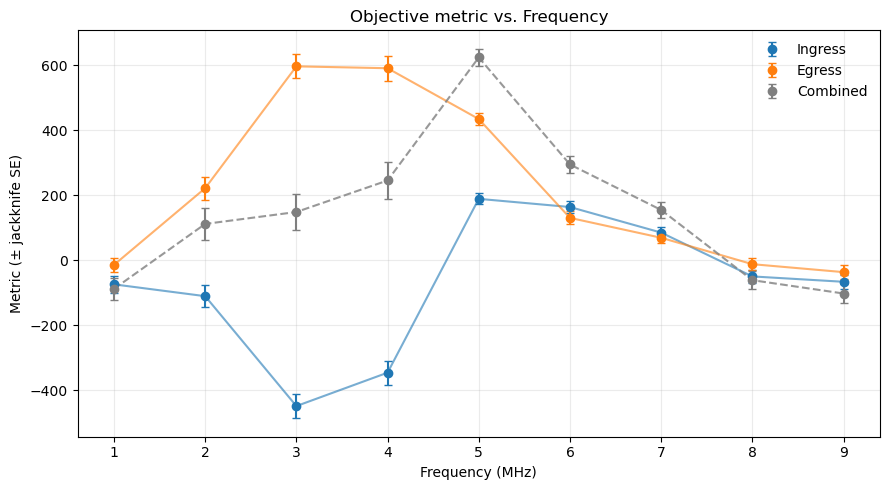

In [ ]:
plot_objective_vs_frequency(res)#blue-orange/combined would be like a signal to noise metric

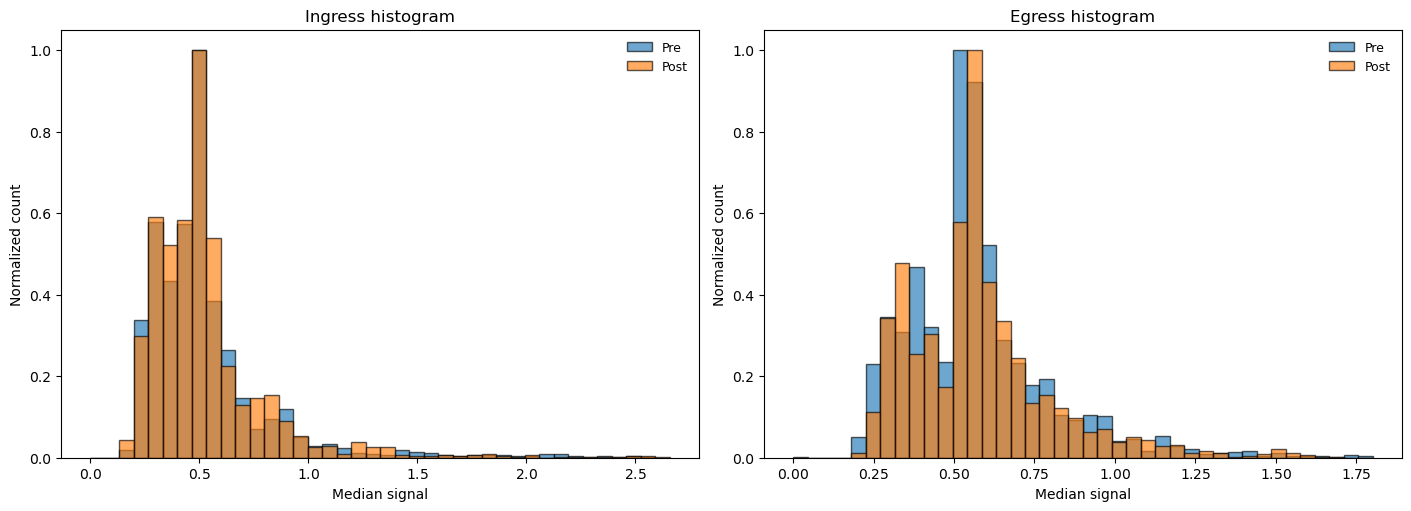

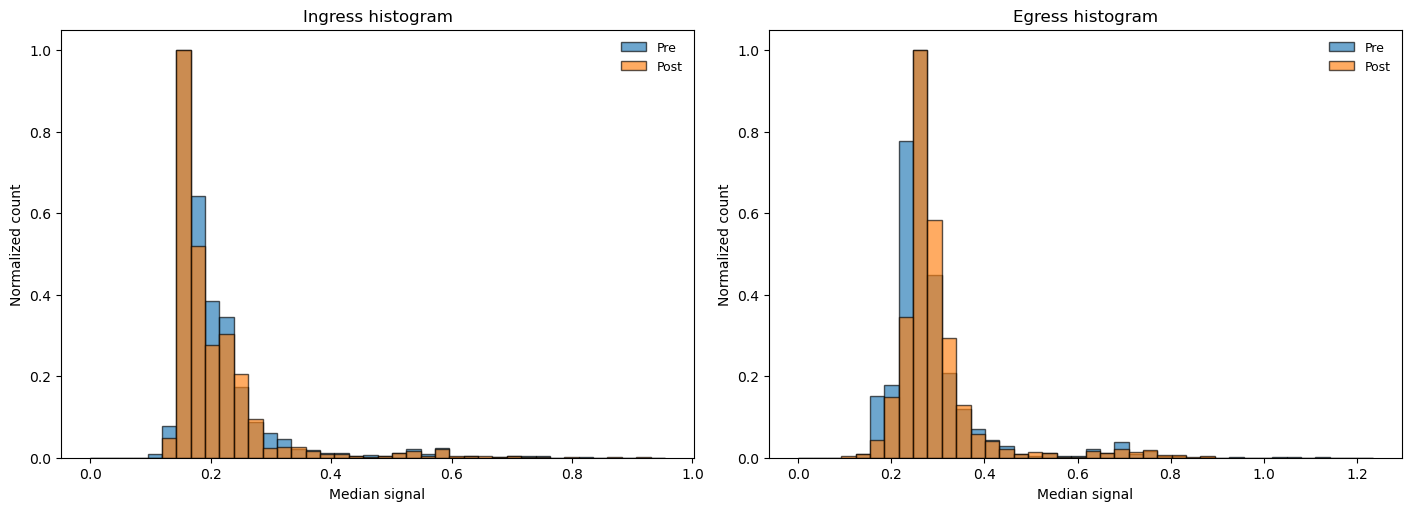

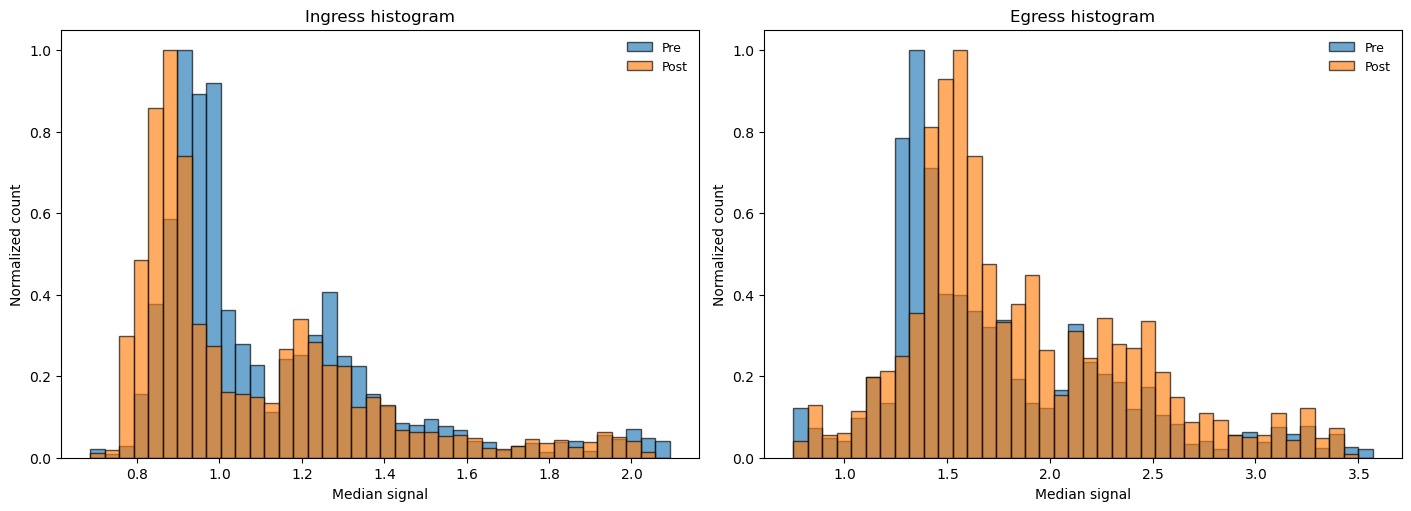

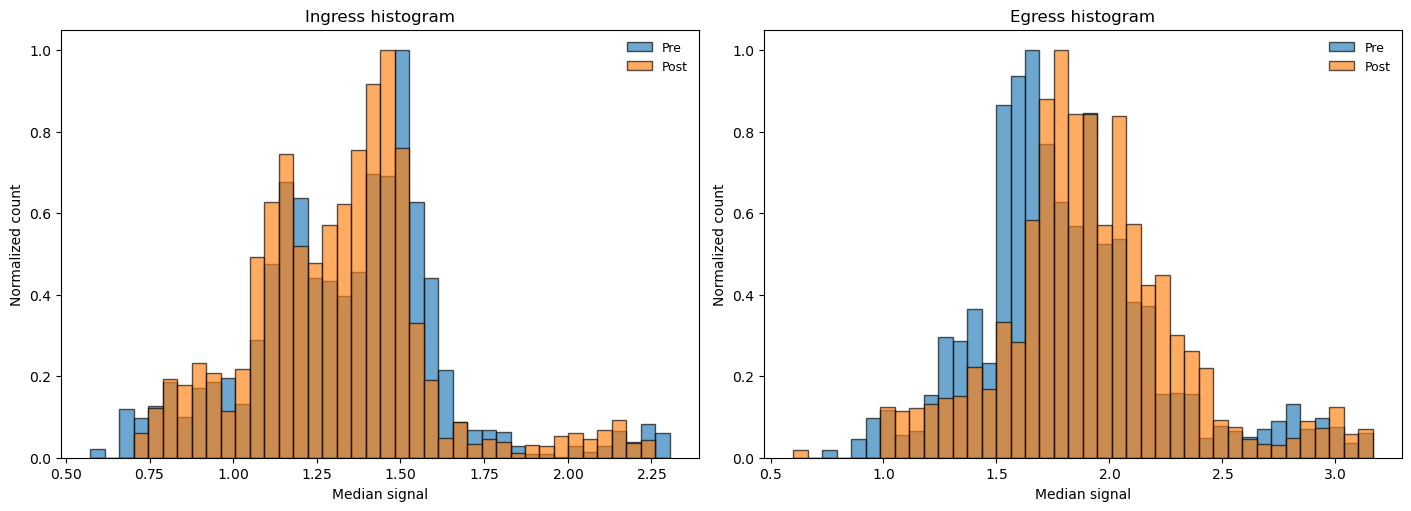

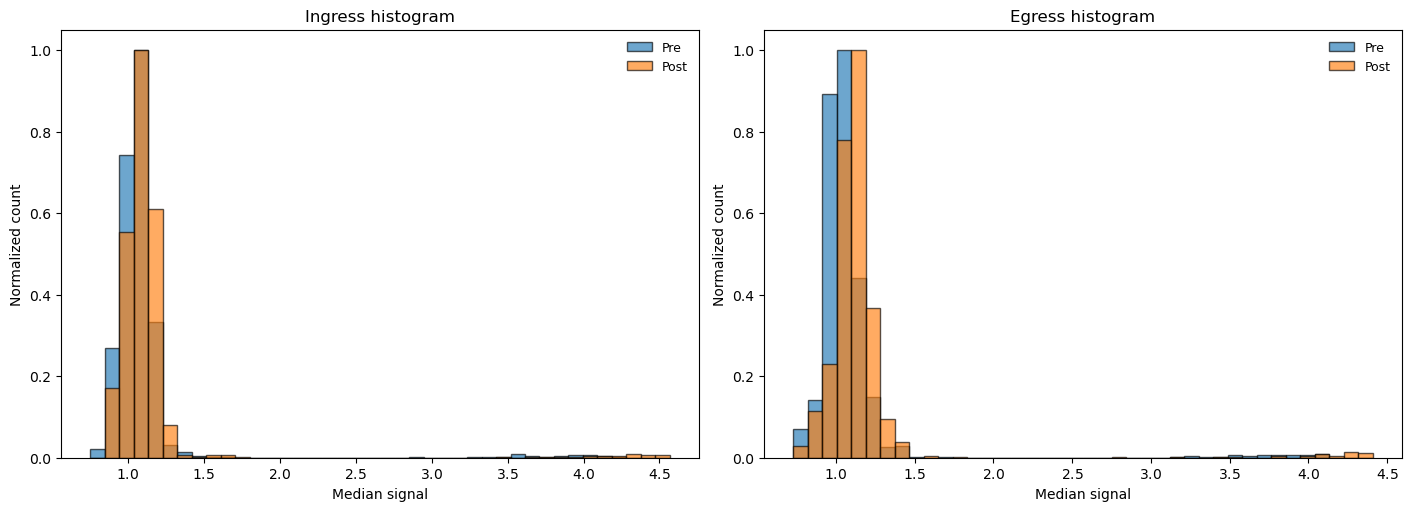

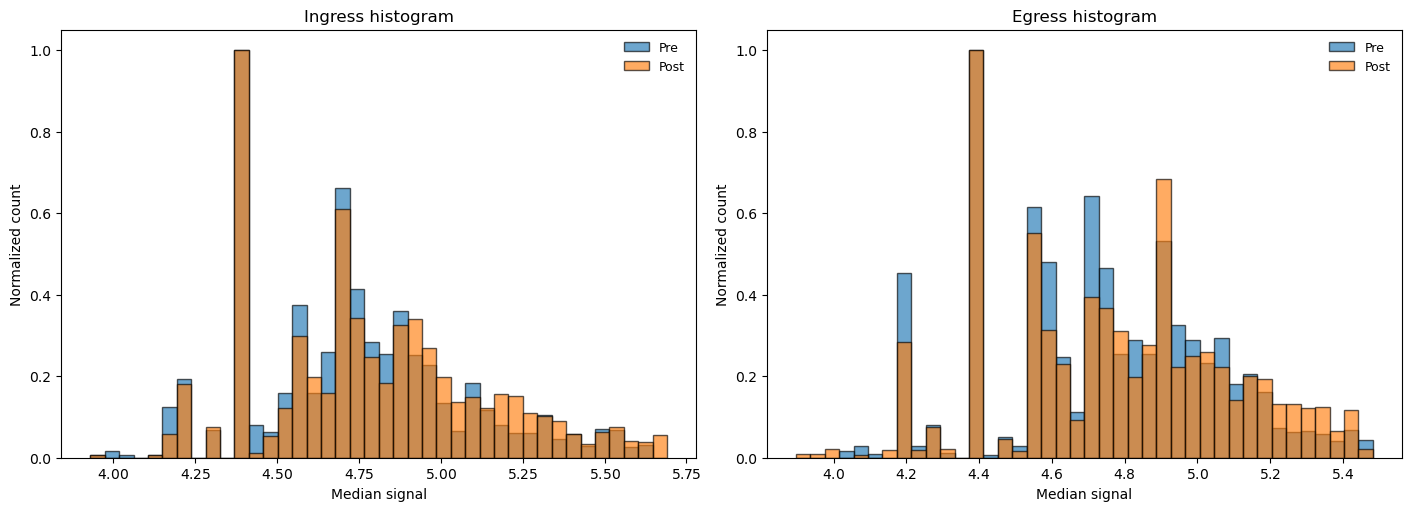

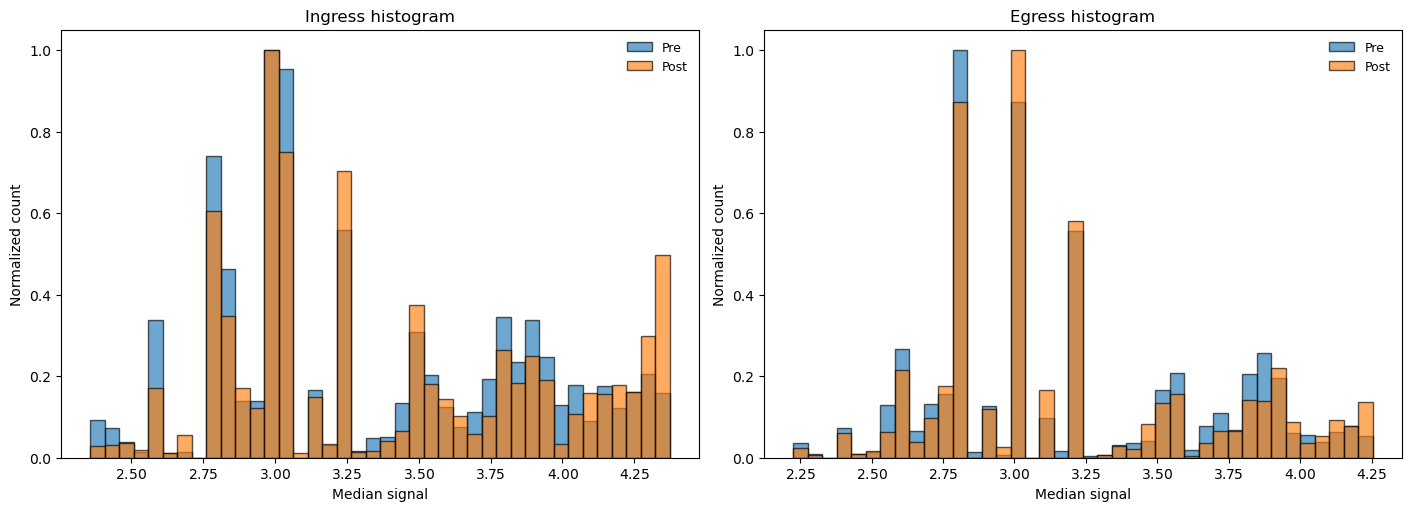

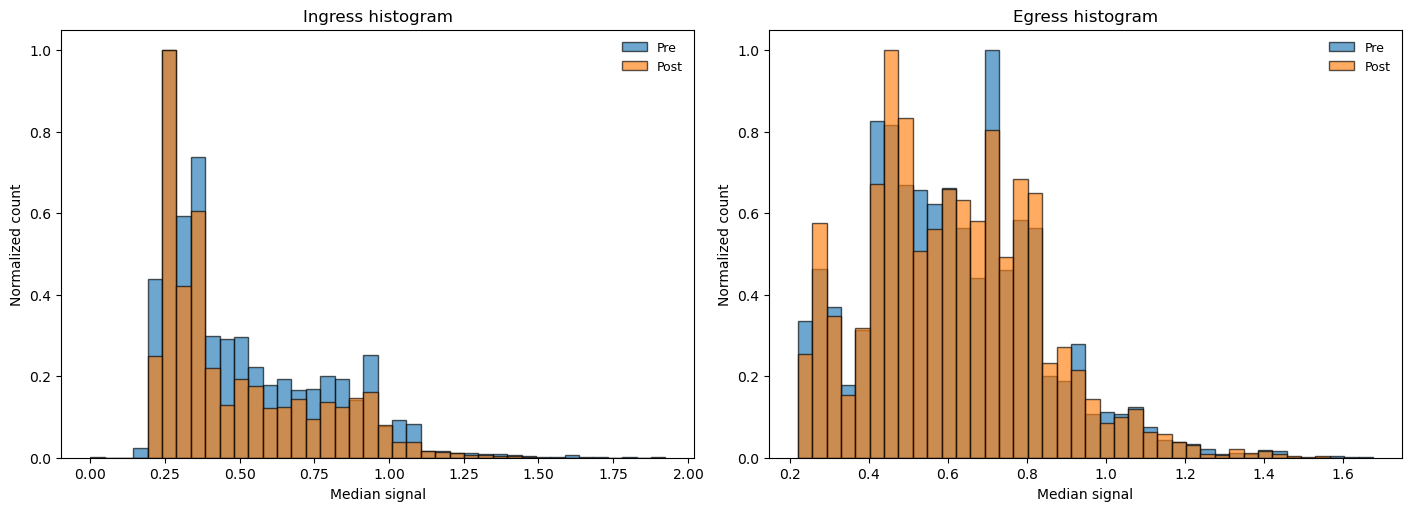

In [13]:
min_bin = [0.5,0.1,0.1,0.05,0.5,0.3,0.3,0.05,0.05]
for i in range(1,9):
    plotIngressEgressHistograms(stats[i],use_std_weights=True,min_bin_percentage=min_bin[i-1])

1


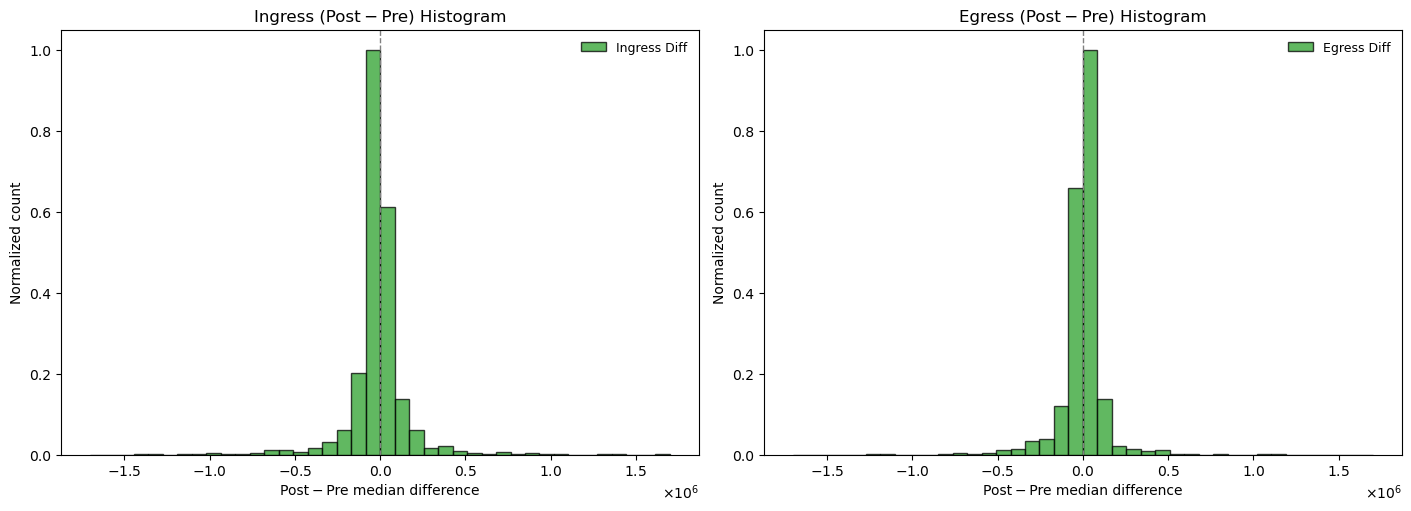

2


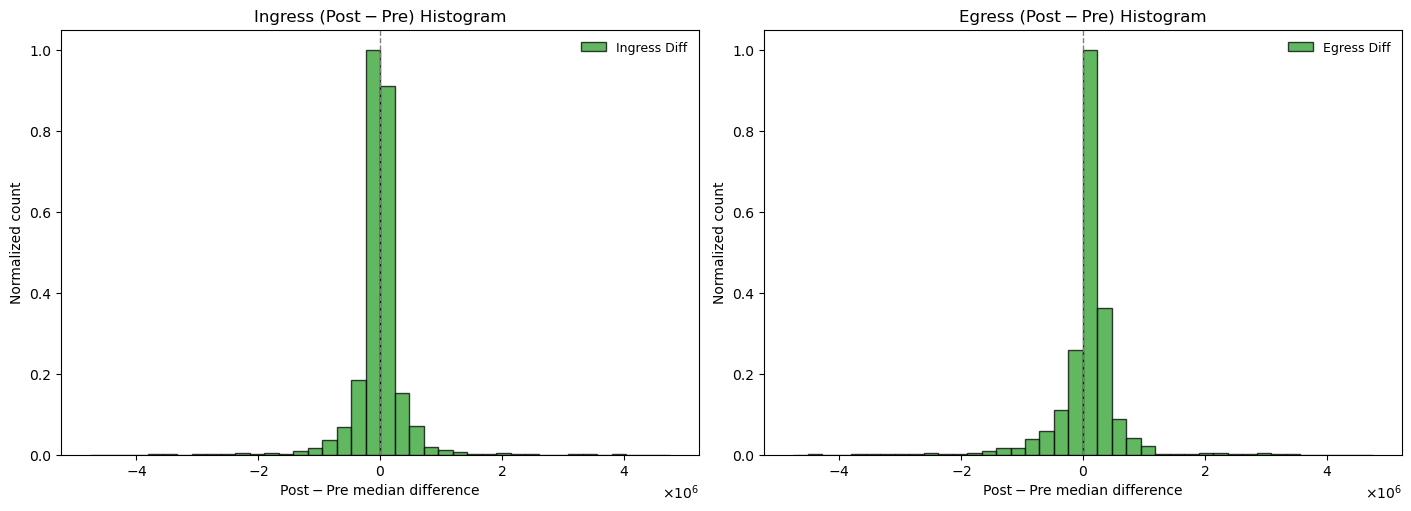

3


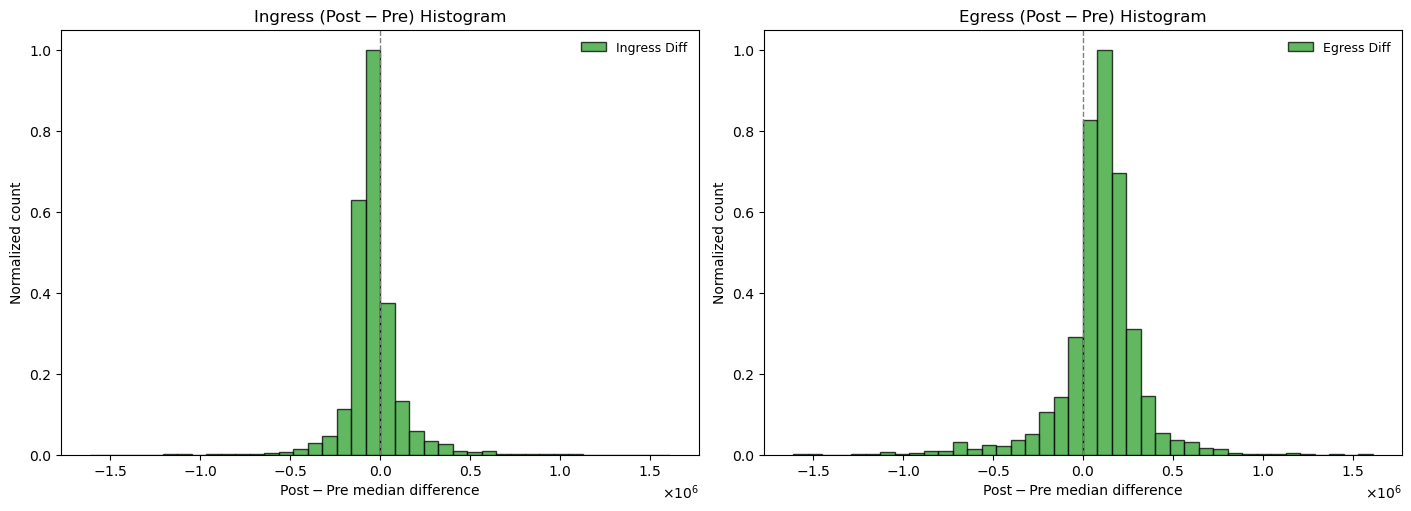

4


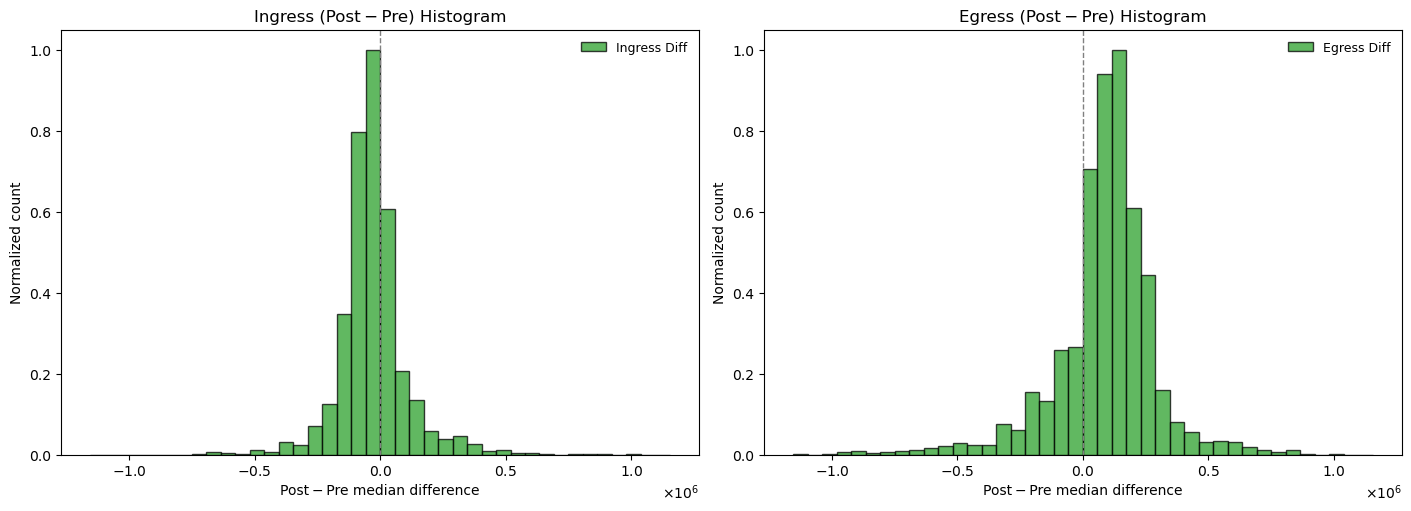

5


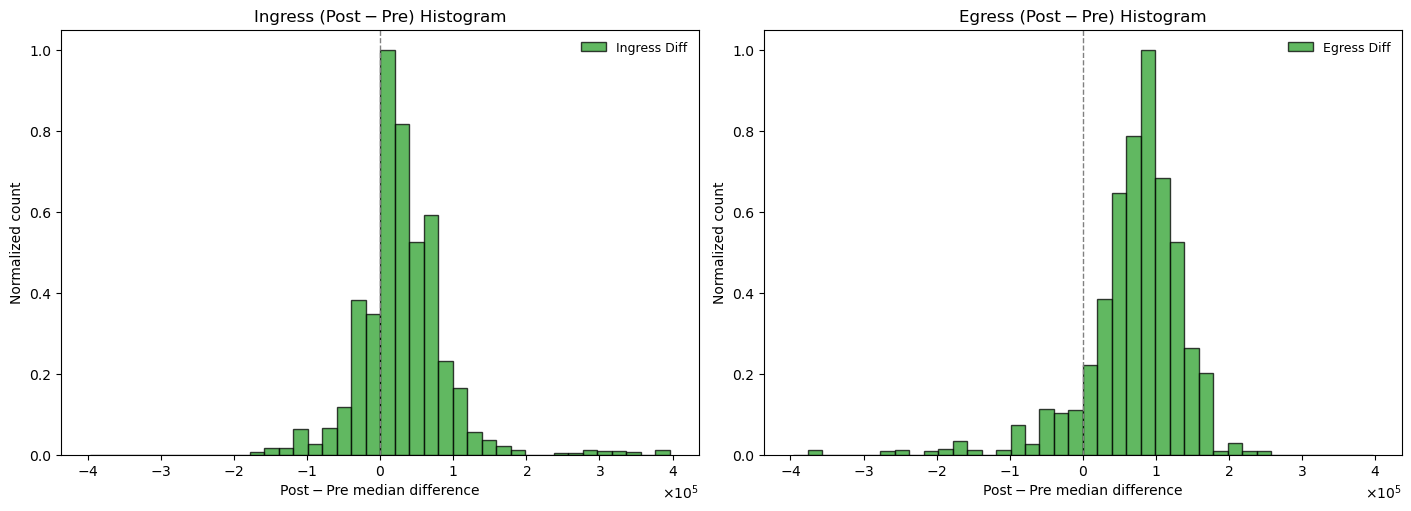

6


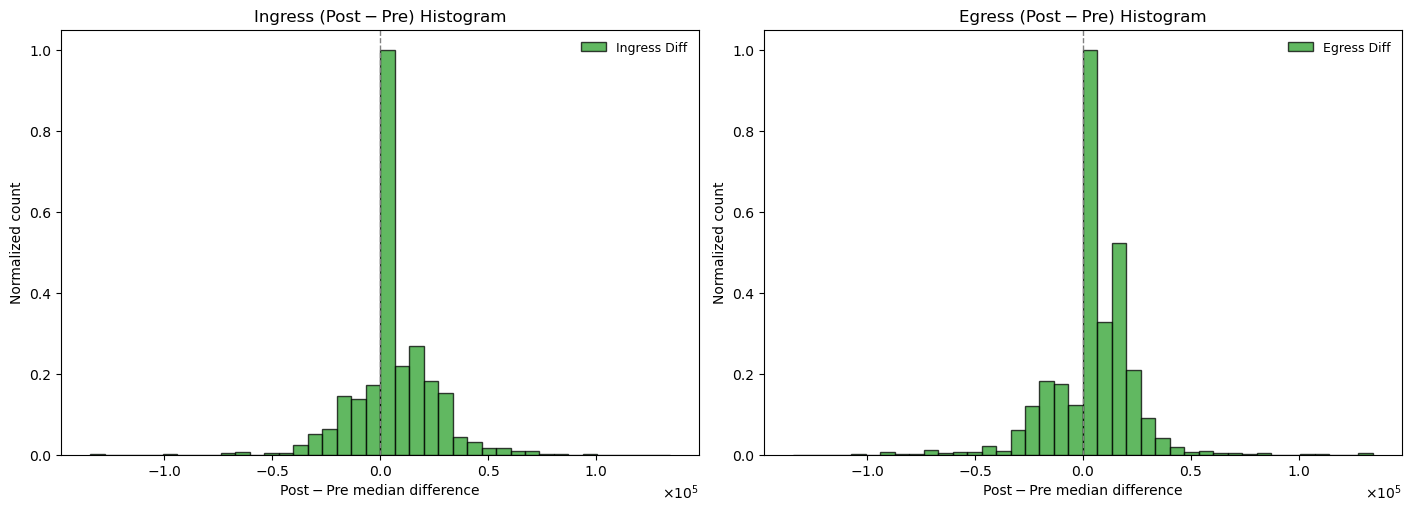

7


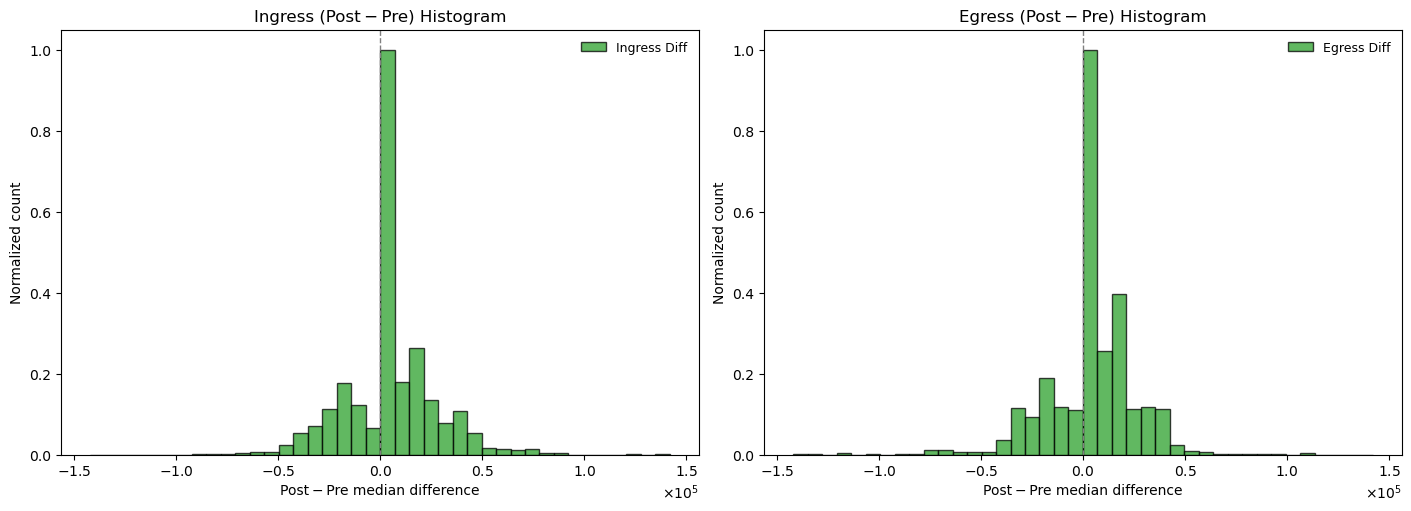

8


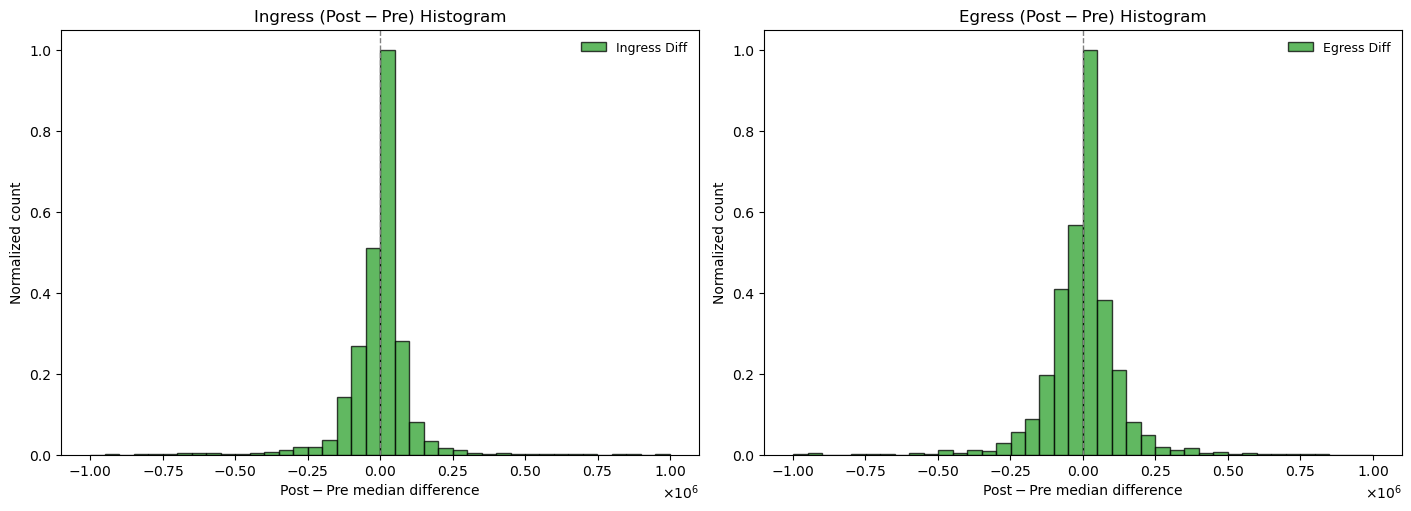

In [20]:
binperc = [0.6,0.2,0.1,0.1,0.6,0.3,0.3,0.1,0.1]
for i in range(1,9):
    print(i)   
    plotIngressEgressDiffHistograms(stats[i],use_std_weights=True,min_bin_percentage=binperc[i-1])#dont let there be a bin at 0, clearly divide between negative and postive

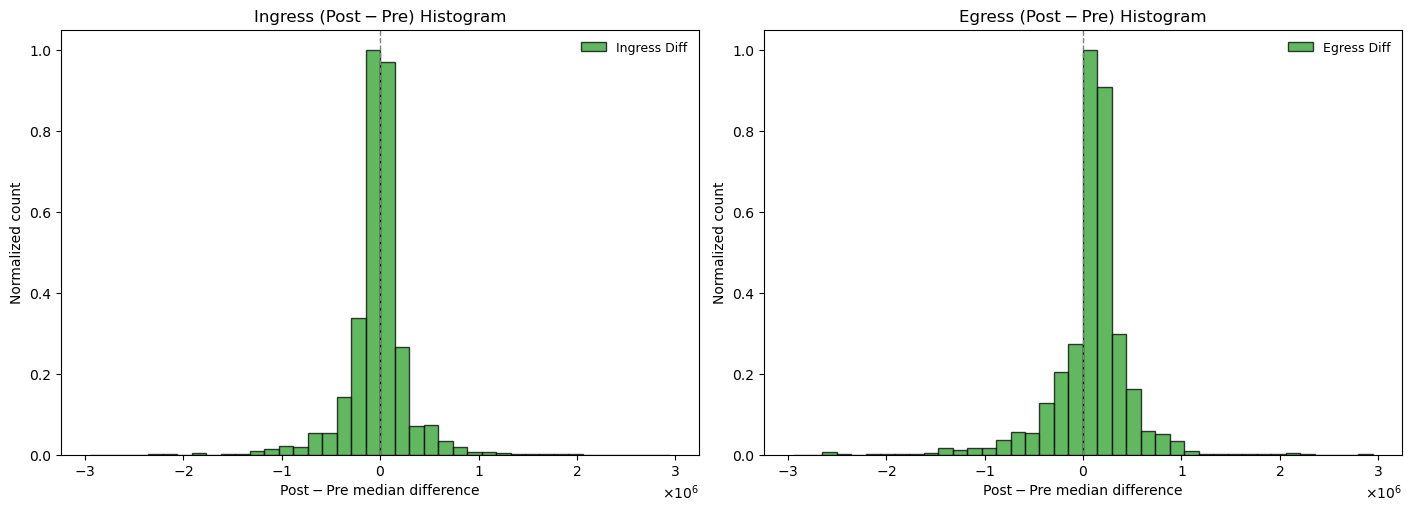

In [15]:
plotIngressEgressDiffHistograms(stats[2],use_std_weights=True,min_bin_percentage=0.3)#dont let there be a bin at 0, clearly divide between negative and postive